### Підготовка датасету

In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.models as models

from PIL import Image
import cv2
import albumentations as A

import time
import os
from tqdm import tqdm

import segmentation_models_pytorch as smp

In [2]:
n_classes = 24
imgs_path = './dataset/semantic_drone_dataset/original_images/'
masks_path = './dataset/semantic_drone_dataset/label_images_semantic/'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)


def create_df():
    name = []
    for dirname, _, filenames in os.walk(imgs_path):
        for filename in filenames:
            name.append(filename.split('.')[0])

    return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

df = create_df()
print('Total Images: ', len(df))

cpu
Total Images:  400


In [3]:
#split data
X_train, X_val = train_test_split(df['id'].values, test_size=0.15, random_state=19)

print('Train Size   : ', len(X_train))
print('Val Size     : ', len(X_val))

Train Size   :  340
Val Size     :  60


In [4]:
class DroneDataset(Dataset):

    def __init__(self, img_path, mask_path, X, mean, std, transform=None, patch=False):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
        self.patches = patch
        self.mean = mean
        self.std = std

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)

        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']

        if self.transform is None:
            img = Image.fromarray(img)

        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        img = t(img)
        mask = torch.from_numpy(mask).long()

        if self.patches:
            img, mask = self.tiles(img, mask)

        return img, mask

    def tiles(self, img, mask):
        img_patches = img.unfold(1, 512, 512).unfold(2, 768, 768)
        img_patches  = img_patches.contiguous().view(3,-1, 512, 768)
        img_patches = img_patches.permute(1,0,2,3)

        mask_patches = mask.unfold(0, 512, 512).unfold(1, 768, 768)
        mask_patches = mask_patches.contiguous().view(-1, 512, 768)

        return img_patches, mask_patches

In [5]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

# t_train = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(), A.VerticalFlip(),
#                      A.GridDistortion(p=0.2), A.RandomBrightnessContrast((0,0.5),(0,0.5)),
#                      A.GaussNoise()])

# t_val = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(),
#                    A.GridDistortion(p=0.2)])


t_train = A.Compose([A.Resize(256, 256, interpolation=cv2.INTER_NEAREST)])

t_val = A.Compose([A.Resize(256, 256, interpolation=cv2.INTER_NEAREST)])

#datasets
train_set = DroneDataset(imgs_path, masks_path, X_train, mean, std, t_train, patch=False)
val_set = DroneDataset(imgs_path, masks_path, X_val, mean, std, t_val, patch=False)

#dataloader
batch_size = 8

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)

In [6]:
def predict_image_mask_miou(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    model.to(DEVICE); image=image.to(DEVICE)
    mask = mask.to(DEVICE)
    with torch.no_grad():

        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)

        output = model(image)
        print("Output shape:", output.shape)  # Shape from the model
        print("Mask shape:", mask.shape)      # Shape of ground truth

        score = mIoU(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, score

In [77]:
def plot_loss(history):
    # plt.plot(history['val_loss'], label='val', marker='o')
    plt.plot( history['train_loss'], label='loss', marker='o')
    plt.title('Loss per epoch'); plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

def plot_score(history):
    plt.plot(history['train_miou'], label='mIoU', marker='*')
    # plt.plot(history['val_miou'], label='val_mIoU',  marker='*')
    plt.title('Score per epoch'); plt.ylabel('mean IoU')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

def plot_acc(history):
    plt.plot(history['train_acc'], label='accuracy', marker='*')
    # plt.plot(history['val_acc'], label='val_accuracy',  marker='*')
    plt.title('Accuracy per epoch'); plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

### Моделі

**Популярні моделі**

* FCN («Fully Convolutional Network», convolutional layers instead of fully connected flat ones) для pixel-level класифікації з використовустанням попередньо навченої мережі класифікації, наприклад, VGG16.
* Найдосконаліші методи виявлення об'єктів також роблять сегментацію екземплярів і оцінюють маску сегментації для кожного виявленого об'єкта. Mask R-CNN додає гілку до моделі Faster R-CNN, щоб оцінити маску для кожної виявленої області інтересу (region of interest).
* U-Net поєднує FCN із skip connections для точного сегментування зі збереженням дрібних деталей.
* ResNet-50, ResNet-101 - Skip connections improve gradient flow, making it more robust for feature extraction. Works well for high-resolution imagery in aerial data. "bottleneck"-блоки
* PSPNet використовує pyramid pooling модуль для покращення контекстної інформації в різних масштабах.
* DeepLab використовує спеціальні механізми для покращення якості сегментації навіть у складних умовах, наприклад, при зображеннях з неоднорідним масштабом об'єктів.

**Новітні моделі**

* Segment Anything Model (SAM) by Meta AI
Ця модель дозволяє сегментувати об'єкти за будь-якими підказками, забезпечуючи високу якість масок. Її застосовують для створення псевдопідписів у навчанні з перенесенням, наприклад, у методах GroundingSAM.

* DINOv2 з Vision Transformer (ViT)
Для семантичної сегментації використовуються версії DINOv2 з ViT-L, ViT-B і ViT-S. Вони забезпечують високу точність завдяки адаптації трансформерів для роботи з зображеннями.

* Mask2Former
Ця модель вдосконалює підхід MaskFormer, трактуючи семантичну сегментацію як задачу класифікації масок, а не покадрової класифікації пікселів. Mask2Former використовує поєднання декодера пікселів і трансформер-декодера.

**Popular Encoders for Feature Extraction**

VGG16/VGG19: Simple architecture; effective for smaller datasets.
Pretrained on ImageNet, suitable for extracting lower and mid-level features.

ResNet (ResNet-50, ResNet-101): Skip connections improve gradient flow, making it more robust for feature extraction.
Works well for high-resolution imagery in aerial data.

EfficientNet: Scalable and computationally efficient.
Performs well on datasets with limited labeled data.

DenseNet: Dense connectivity helps retain fine-grained details, useful for segmentation.

MobileNet: Lightweight and efficient, suitable for drone datasets with resource constraints.

Vision Transformers (ViT): Recent advancements in segmentation tasks.
Better at capturing global relationships but may require fine-tuning.



---


**Segmentation Architectures with Pretrained Encoders**

These models combine a feature extractor (encoder) with a segmentation head (decoder).

U-Net (and U-Net++): Popular for aerial and medical image segmentation.
Encoder pretrained on ImageNet (e.g., ResNet, EfficientNet).

DeepLabv3/DeepLabv3+: Uses atrous convolution for multi-scale context.
Compatible with ResNet, Xception, or EfficientNet as pretrained encoders.

SegNet: Encoder-decoder architecture with VGG16 as the default encoder.
Effective for dense pixel-wise prediction.

PSPNet (Pyramid Scene Parsing Network): Incorporates global context information.
Compatible with ResNet or DenseNet encoders.



---



**Pretrained Weights Sources**

ImageNet: Widely available pretrained encoders for ImageNet.
Useful for general feature extraction.

COCO: If available, models pretrained on COCO datasets can improve performance on datasets with complex object interactions.

Satellite/Aerial Pretrained Models: Datasets like DOTA, xView, or SpaceNet provide pretrained encoders for aerial image tasks. Models fine-tuned on these datasets may offer better starting points than generic ImageNet weights.

#### Модель 1 - FCN8 з VGG16 backbone та pretrained вагами на датасеті ImageNet

За результатами статті "Fully Convolutional Networks for Semantic Segmentation" by Long, Shelhamer, and Darrell із завдання найкраще у співвідношенні кількості використаних ресурсів/результату показала себе FCN8.

Skip Connections: output=upsample(conv7+pool4+pool3). Combines feature maps from both the pool4 layer (output stride 16) and the pool3 layer (output stride 8) with the upsampled predictions from deeper layers (like pool5).

Upsampling:
Uses a stride of 8 to upsample the feature maps to the original image size.

Trade-Off:
Resolution: Produces higher-resolution predictions due to finer feature maps (pool3) being used in skip connections.

More accurate than FCN16 because it includes higher spatial detail from shallower layers. Slightly slower and more computationally expensive than FCN16 due to additional upsampling steps and operations.

ImageNet is a dataset that consists of 1,000 classes and over a million images.



---


VGG16 - a popular deep convolutional neural network introduced in the paper "Very Deep Convolutional Networks for Large-Scale Image Recognition" by Karen Simonyan and Andrew Zisserman in 2014.
It is known for its simplicity, uniform structure, and use of small 3×3 filters. VGG16 has 16 weight layers (13 convolutional + 3 fully connected layers). Uses Relu activation function.

Uses only small 3×3 convolution filters with a stride of 1 and padding of 1.
Includes max-pooling layers (2×2, stride 2) for spatial downsampling.
Ends with three fully connected layers for classification (default softmax at the last layer).

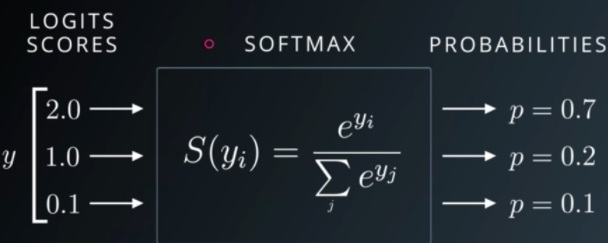

In [ ]:
from torchvision.models import VGG16_Weights

class FCN8_Pretrained(nn.Module):
    def __init__(self, num_classes=24):
        super(FCN8_Pretrained, self).__init__()

        vgg16 = models.vgg16(weights=VGG16_Weights.DEFAULT)
        self.features = vgg16.features

        self.fc6 = nn.Conv2d(512, 1024, kernel_size=7)
        self.relu6 = nn.ReLU(inplace=True)
        self.drop6 = nn.Dropout2d()

        self.score_pool3 = nn.Conv2d(256, num_classes, kernel_size=1)
        self.score_pool4 = nn.Conv2d(512, num_classes, kernel_size=1)
        self.score_fc6 = nn.Conv2d(1024, num_classes, kernel_size=1)

        self.upscore2 = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=14, stride=2, padding=0)
        self.upscore_pool4 = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=4, stride=2, padding=1)
        self.upscore8 = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=16, stride=8, padding=4)

    def forward(self, x):
        pool3 = self.features[:17](x)
        pool4 = self.features[17:24](pool3)
        pool5 = self.features[24:](pool4)

        fc6 = self.drop6(self.relu6(self.fc6(pool5)))
        score_fc6 = self.score_fc6(fc6)

        score_pool4 = self.score_pool4(pool4)
        upscore_pool4 = self.upscore2(score_fc6) + score_pool4

        score_pool3 = self.score_pool3(pool3)
        upscore8 = self.upscore_pool4(upscore_pool4) + score_pool3

        out = self.upscore8(upscore8)

        return out


model = FCN8_Pretrained(num_classes=24)

Before tuning to this dataset, without training.

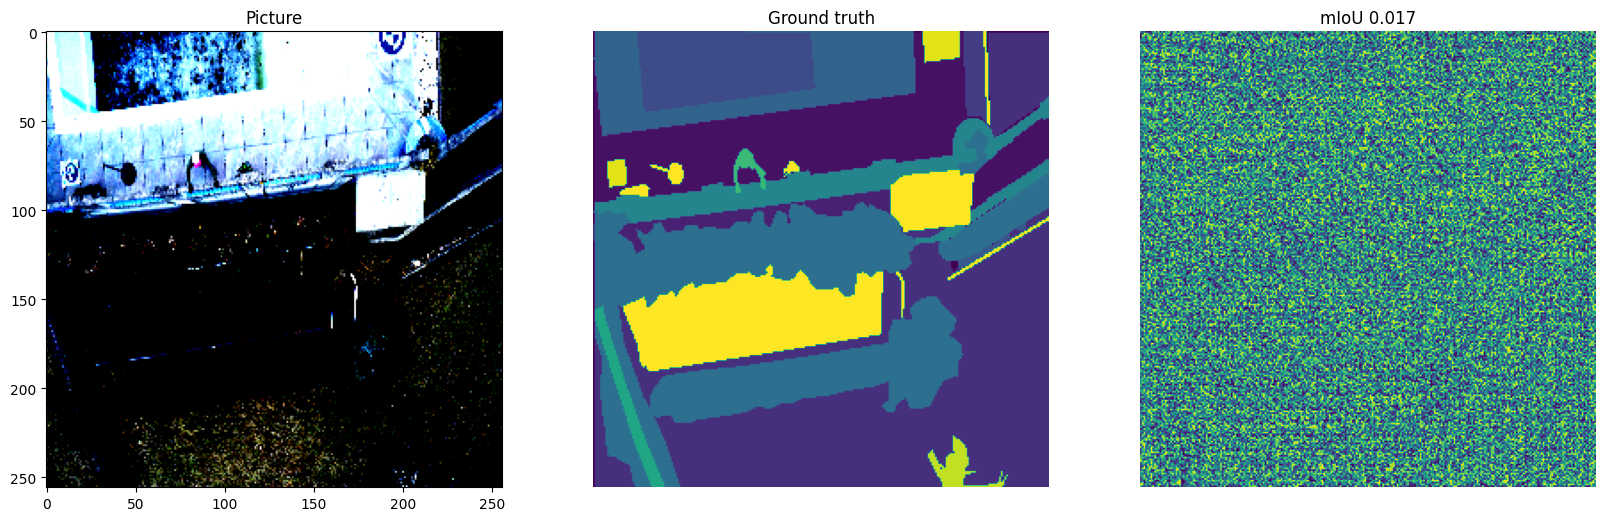

In [8]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU6(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU6(inplace=True)
            )

    def forward(self, x):
        return self.conv(x)

In [ ]:
from torchvision.models import VGG16_Weights

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import vgg16

class FCN8_Pretrained_Improved(nn.Module):
    def __init__(self,
                 input_shape=(3, 256, 256),
                 num_classes=24,
                 num_conv_filters=1024):
        super(FCN8_Pretrained_Improved, self).__init__()

        self.num_classes = num_classes
        self.num_conv_filters = num_conv_filters

        vgg = vgg16(weights=VGG16_Weights.DEFAULT)
        self.features = vgg.features

        self.fc6 = DoubleConv(512, 756)
        self.drop6 = nn.Dropout(0.5)

        self.fc7 = DoubleConv(756, num_conv_filters)
        self.drop7 = nn.Dropout(0.5)

        self.fc8 = DoubleConv(num_conv_filters, 512)
        self.drop8 = nn.Dropout(0.5)
        
        self.score_fr = nn.Conv2d(512, 64, kernel_size=(1, 1), stride=(1, 1))
        # self.score_fr = DoubleConv(512, 64)

        self.upscore2 = nn.ConvTranspose2d(64, 64, kernel_size=4, stride=2, padding=1, bias=False)
        self.score_pool4 = DoubleConv(512, 64)
        self.upscore_pool4 = nn.ConvTranspose2d(64, num_classes, kernel_size=4, stride=2, padding=1, bias=False)
        self.score_pool3 = DoubleConv(256, num_classes)
        self.upscore8 = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=16, stride=8, padding=4, bias=False)
        

    def forward(self, x):
        pool3 = None
        pool4 = None

        for i, layer in enumerate(self.features):
            x = layer(x)
            if i == 16:
                pool3 = x
            if i == 23:
                pool4 = x
        pool5 = x

        x = self.fc6(pool5)
        x = self.drop6(x)

        x = self.fc7(x)
        x = self.drop7(x)

        x = self.fc8(x)
        x = self.drop8(x)

        x = self.score_fr(x)

        x = self.upscore2(x)
        pool4_score = self.score_pool4(pool4)
        x = x + pool4_score

        x = self.upscore_pool4(x)
        pool3_score = self.score_pool3(pool3)
        x = x + pool3_score

        x = self.upscore8(x)

        return x

model = FCN8_Pretrained_Improved()
model

FCN8_Pretrained_Improved(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, 

In [ ]:
trained_model_fcn8_vgg16 = torch.load('./models/FCN8_VGG16_ImageNet.pt')

In [21]:
image, mask = val_set[5]
pred_mask, score = predict_image_mask_miou(model, image, mask)

Output shape: torch.Size([1, 24, 256, 256])
Mask shape: torch.Size([1, 256, 256])


**AdamW Optimizer та CrossEntropy pixel-wise loss function; epoch = 15, learning_rate = 0.001 to 0.0005 to 0.0002 to 0.00009, weight_decay = 0.0001**


100%
 43/43 [19:44<00:00, 23.40s/it]
Epoch:1/5.. Loss: 2.166.. mIoU:0.043.. Pixel Accuracy:0.373.. Time: 19.75m

100%
 43/43 [19:26<00:00, 22.64s/it]
Epoch:2/5.. Loss: 1.342.. mIoU:0.128.. Pixel Accuracy:0.607.. Time: 19.45m

100%
 43/43 [19:26<00:00, 22.90s/it]
Epoch:3/5.. Loss: 1.220.. mIoU:0.161.. Pixel Accuracy:0.654.. Time: 19.44m

100%
 43/43 [19:41<00:00, 22.64s/it]
Epoch:4/5.. Loss: 0.955.. mIoU:0.196.. Pixel Accuracy:0.712.. Time: 19.71m

100%
 43/43 [19:54<00:00, 22.73s/it]
Epoch:5/5.. Loss: 0.870.. mIoU:0.215.. Pixel Accuracy:0.733.. Time: 19.91m
Total time: 98.26 m

100%
 43/43 [19:53<00:00, 23.58s/it]
Epoch:1/2.. Loss: 0.892.. mIoU:0.216.. Pixel Accuracy:0.725.. Time: 19.89m

100%
 43/43 [19:50<00:00, 24.39s/it]
Epoch:2/2.. Loss: 0.790.. mIoU:0.251.. Pixel Accuracy:0.752.. Time: 19.91m
Total time: 39.80 m

100%|██████████| 43/43 [08:15<00:00, 11.52s/it]
Epoch:1/2.. Loss: 0.807.. mIoU:0.274.. Pixel Accuracy:0.751.. Time: 8.26m

100%|██████████| 43/43 [07:36<00:00, 10.61s/it]
Epoch:2/2.. Loss: 0.687.. mIoU:0.316.. Pixel Accuracy:0.784.. Time: 7.61m
Total time: 15.87 m

100%|██████████| 43/43 [07:03<00:00,  9.84s/it]
Epoch:1/2.. Loss: 0.531.. mIoU:0.411.. Pixel Accuracy:0.831.. Time: 7.06m

100%|██████████| 43/43 [07:55<00:00, 11.07s/it]
Epoch:2/2.. Loss: 0.512.. mIoU:0.421.. Pixel Accuracy:0.838.. Time: 7.94m
Total time: 14.99 m




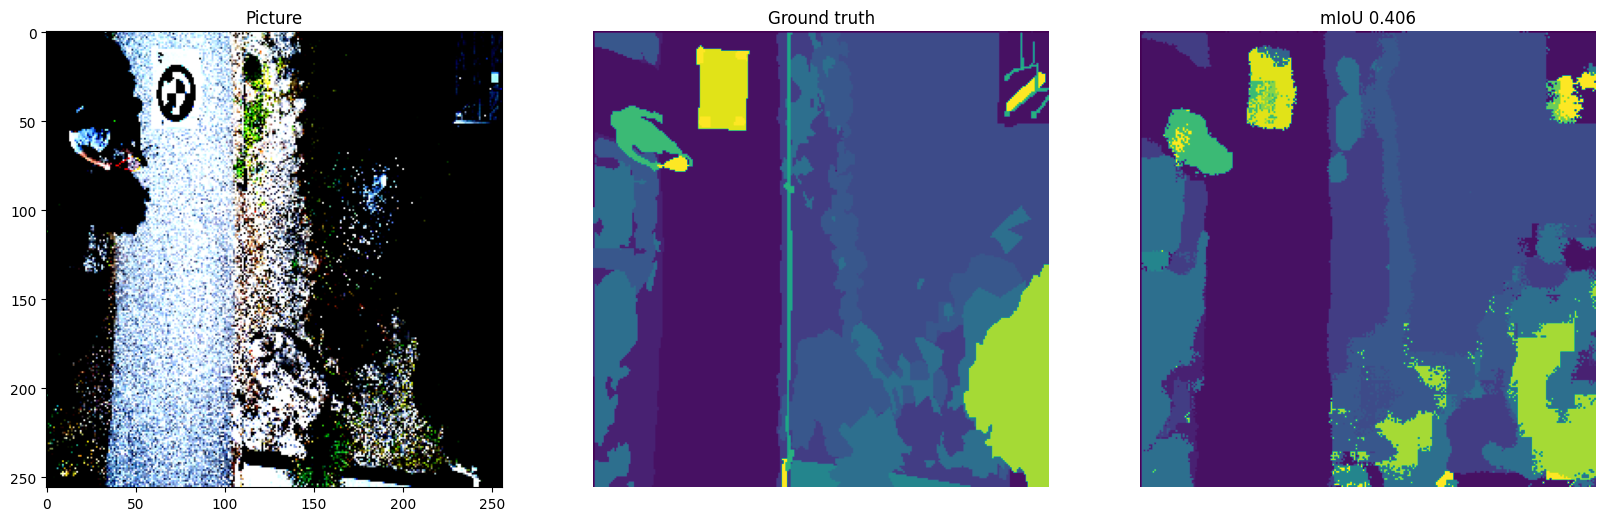

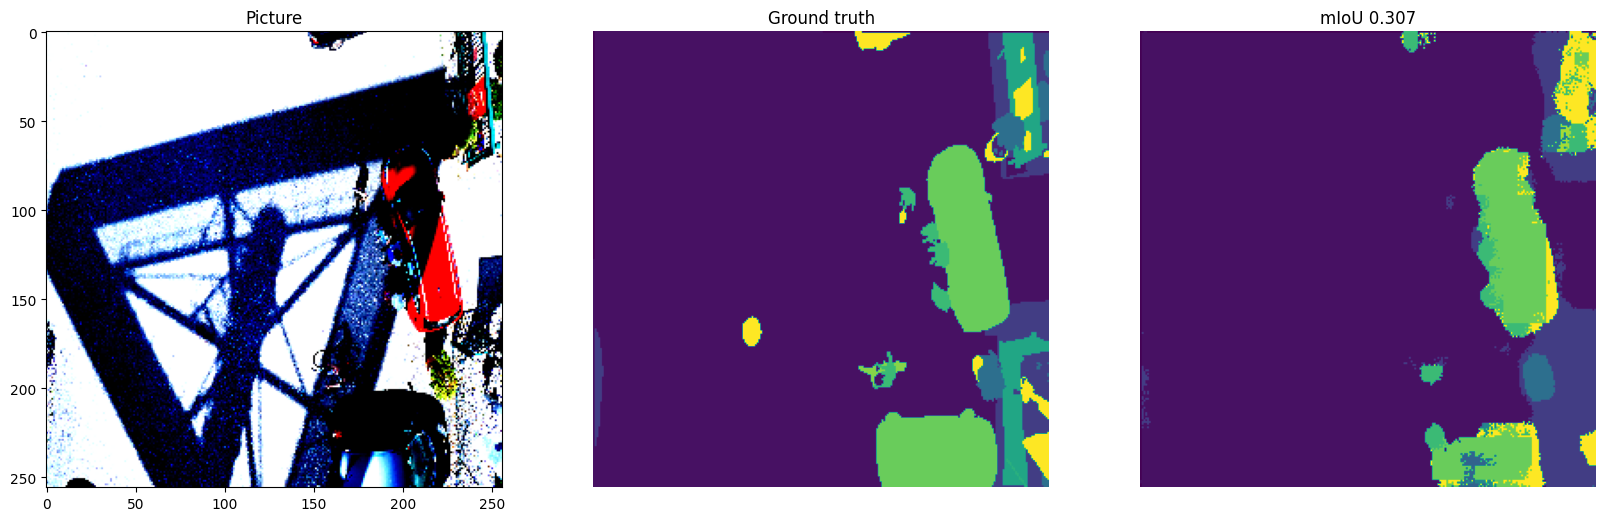

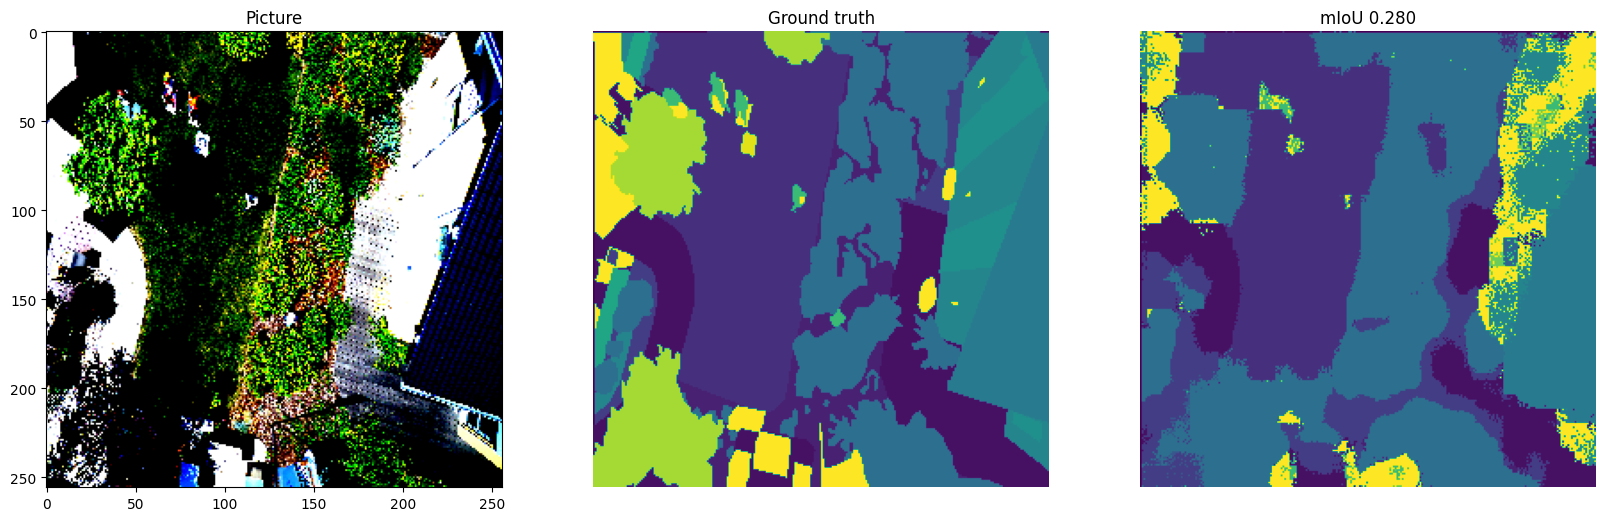

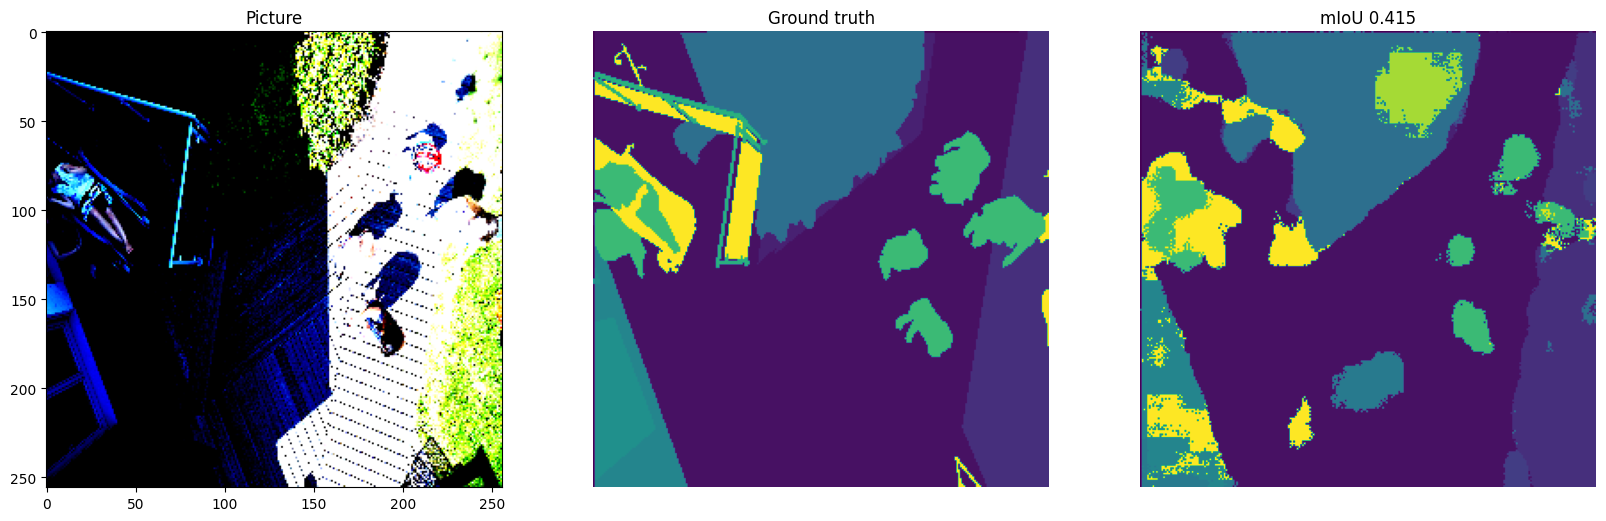

#### Модель 2 - мій U-Net та U-Net  з MobileNetV2 backbone feature extractor та ImageNet натренованими вагами

In [ ]:
# U-net is composed of several blocks with pooling in between. Each block consists of 2 convolutions,
# therefore to not repeat code at each block we define a class that summarizes it

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
            )

    def forward(self, x):
        return self.conv(x)

In [ ]:
class UNET(nn.Module):
    def __init__(self, in_channels=3, out_channels=24, features=[16, 32, 64, 128, 256, 512]):
        super(UNET, self).__init__()
        self.downs      = nn.ModuleList()
        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.ups        = nn.ModuleList()
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)
        self.pool       = nn.MaxPool2d(kernel_size = 2, stride = 2)

        # Down part of U-net
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of U-net
        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2))
            # self.ups.append(nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True))
            self.ups.append(DoubleConv(feature*2, feature))

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)

        # Reverse the skip connections list -> first are going to be used the ones added last
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

#             #If original input shape not divisable by 16
#             if x.shape != skip_connection.shape:
#                 x = TF.resize(x, size=skip_connection.shape[2:])

            skip_connection = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](skip_connection)

        x = self.final_conv(x)
        return x

model = UNET()

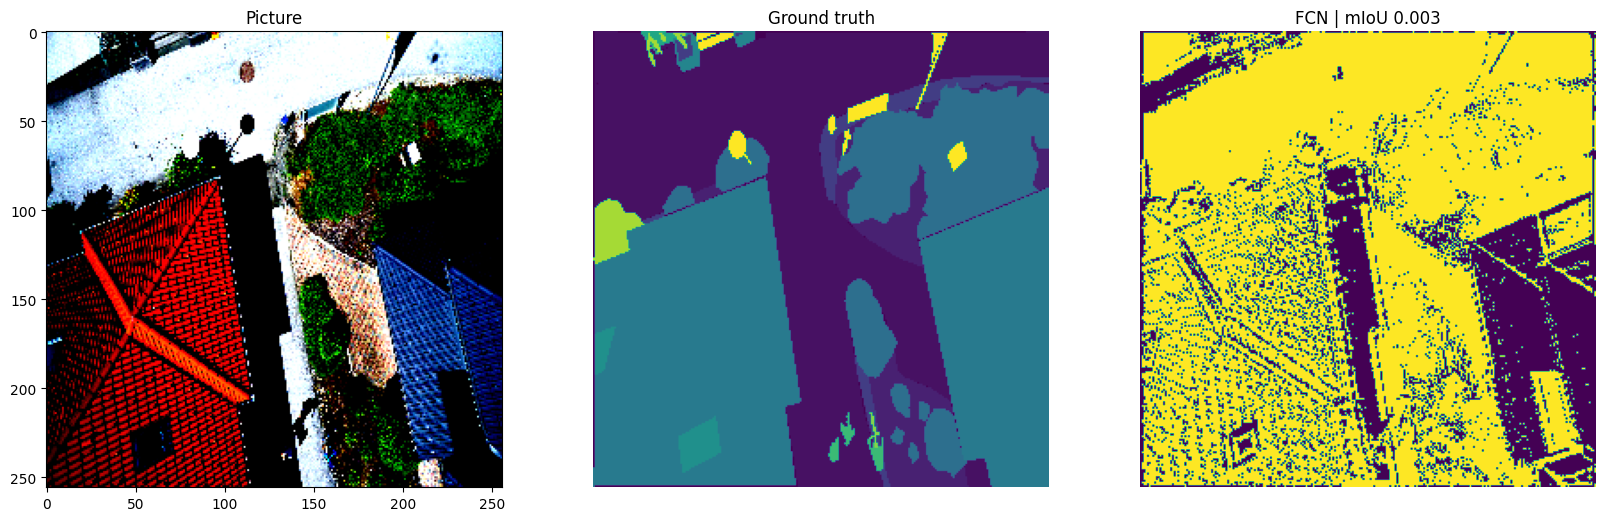

In [ ]:
from torchvision.models import ResNet101_Weights

class UNET_Pretrained(nn.Module):
    def __init__(self, in_channels=3, out_channels=24, features=[32, 64, 128, 256, 512, 1024]):
        super(UNET_Pretrained, self).__init__()
        self.downs = nn.ModuleList()
        self.bottleneck = DoubleConv(1024, 2048)
        self.ups = nn.ModuleList()
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        pretrained_resnet = models.resnet101(weights=ResNet101_Weights.DEFAULT)
        resnet_layers = list(pretrained_resnet.children())

        self.downs.append(nn.Sequential(*resnet_layers[:3]))  # Initial conv and BN
        self.downs.append(resnet_layers[4])  # First residual block
        self.downs.append(resnet_layers[5])  # Second residual block
        self.downs.append(resnet_layers[6])  # Third residual block


        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature * 2, feature, kernel_size=2, stride=2))
            self.ups.append(DoubleConv(feature * 2, feature))

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)

        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups) - 2, 2):
            x = self.ups[idx](x)

            if len(skip_connections) > (idx // 2):
              skip_connection = skip_connections[idx // 2]

              # Handle potential size mismatches
              if x.shape != skip_connection.shape:
                  x = torch.nn.functional.interpolate(x, size=skip_connection.shape[2:])

              if x.shape != skip_connection.shape:
                  skip_connection = DoubleConv(64, 128)(skip_connection)

              x = torch.cat((skip_connection, x), dim=1)
              x = self.ups[idx + 1](x)

            else:
              x = DoubleConv(64 , 32)(x)

        x = self.final_conv(x)
        return x


model = UNET_Pretrained(in_channels=3, out_channels=24)

In [ ]:
model

UNET_Pretrained(
  (downs): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=

Residual block y=F(x)+x

For a Residual Network bottleneck block (used in ResNet50/101/152)

* First 1×1 Conv Layer:
Reduces the number of channels (dimensionality reduction)
* 3×3 Conv Layer:
Applies spatial convolution without changing channels
* Second 1×1 Conv Layer:
Increases channels back to the original size (dimensionality expansion)

In [ ]:
image, mask = val_set[2]
pred_mask, score = predict_image_mask_miou(model, image, mask)

Output shape: torch.Size([1, 24, 512, 512])
Mask shape: torch.Size([1, 512, 512])


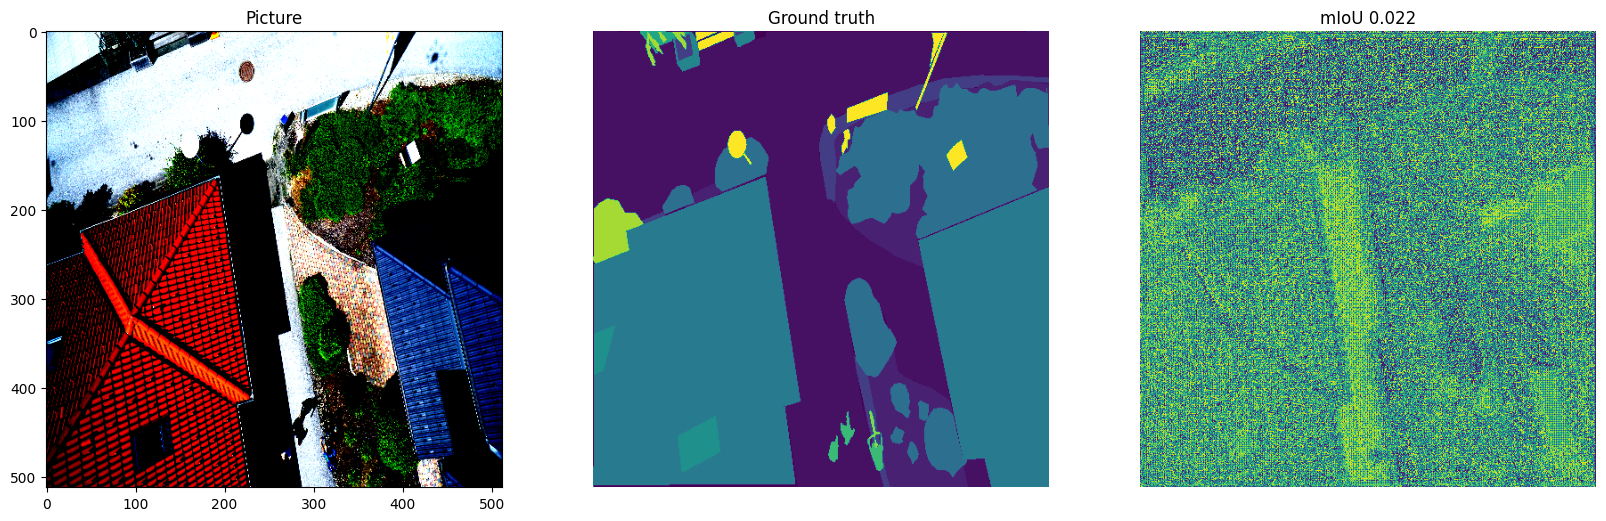

**AdamW Optimizer та CrossEntropy pixel-wise loss function; epoch = 15, learning_rate = 0.001, weight_decay = 0.0001**

Loss Decreasing.. 0.785 >> 0.721
Epoch:10/15.. Train Loss: 0.834.. Val Loss: 0.721.. Train mIoU:0.241.. Val mIoU: 0.244.. Train Acc:0.754.. Val Acc:0.776..

Loss Decreasing.. 0.721 >> 0.675
Epoch:11/15.. Train Loss: 0.773.. Val Loss: 0.675.. Train mIoU:0.257.. Val mIoU: 0.266.. Train Acc:0.771.. Val Acc:0.793..

Loss Decreasing.. 0.675 >> 0.661
Epoch:12/15.. Train Loss: 0.749.. Val Loss: 0.661.. Train mIoU:0.263.. Val mIoU: 0.267.. Train Acc:0.779.. Val Acc:0.798..

Loss Decreasing.. 0.661 >> 0.628
Epoch:13/15.. Train Loss: 0.693.. Val Loss: 0.628.. Train mIoU:0.273.. Val mIoU: 0.281.. Train Acc:0.795.. Val Acc:0.809..

Loss Decreasing.. 0.628 >> 0.607
Epoch:14/15.. Train Loss: 0.679.. Val Loss: 0.607.. Train mIoU:0.279.. Val mIoU: 0.290.. Train Acc:0.801.. Val Acc:0.816..

In [ ]:
plot_loss(history)
plot_score(history)

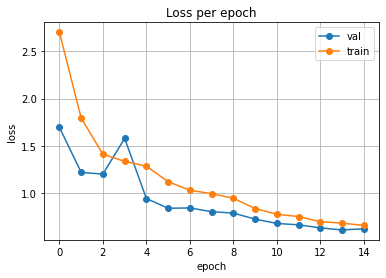

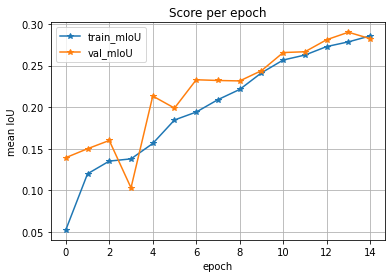

Test images

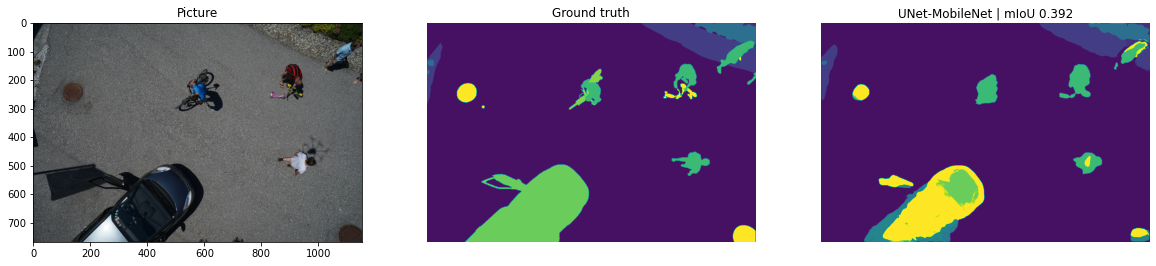

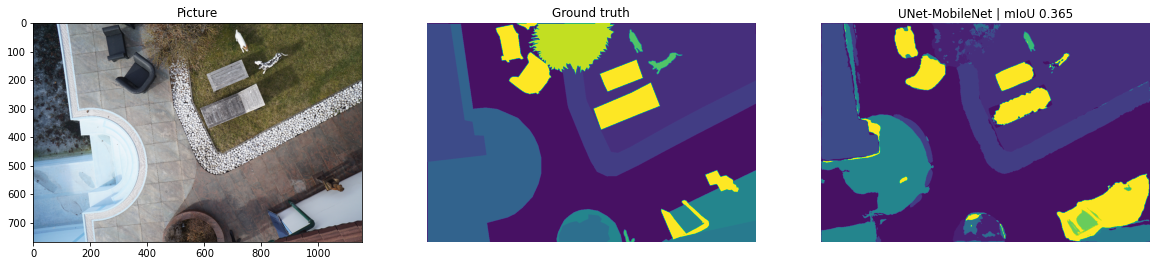

##### Модель для огляду структури

In [ ]:
# U-Net CNN model using the Segmentation Models PyTorch (smp) library
model = smp.Unet('mobilenet_v2', encoder_weights='imagenet', classes=24, activation=None, encoder_depth=5, decoder_channels=[256, 128, 64, 32, 16])

In [ ]:
model

Unet(
  (encoder): MobileNetV2Encoder(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_size=(1

* Encoder extracts high-level features (downsampling).
* Decoder reconstructs the spatial details and resolution (upsampling).

1. Кодувальник (Feature Extractor):
Використовує MobileNetV2 як основу. MobileNetV2 — це легка та ефективна нейронна мережа, розроблена для мобільних пристроїв, яка використовує глибокі роздільні згортки.
Обробляє вхідне зображення через п'ять етапів згорток, поступово зменшуючи просторову роздільну здатність і збільшуючи кількість ознак.
Ініціалізація з вагами ImageNet дозволяє використовувати вже навчений кодувальник для витягування корисних ознак.
Функція активації Relu6 = min(max(0,x),6)
2. Міст (Bridge):
Найглибша частина U-Net з'єднує кодувальник та декодувальник.
Захоплює контекстну інформацію з ознак, витягнутих кодувальником.
3. Декодувальник:
Відновлює просторову роздільну здатність зображення за допомогою транспонованих згорток або шарів збільшення розмірів.
Масив decoder_channels визначає, як кількість каналів зменшується на кожному етапі декодування: 256 → 128 → 64 → 32 → 16. Функція активації Relu = max(0,x)
Декодувальник використовує пропускні з'єднання (skip connections) з кодувальника для покращення локалізації. Тобто деякі дані пропускають певні шари.
4. Вихідний шар:
Створює карту сегментації з 24 каналів (по одному для кожного класу).
Оскільки activation=None, вихідний тензор не містить активацій, тому функцію активації (наприклад, softmax) слід застосовувати окремо під час навчання або передбачення.


#### Модель 3 - DeepLabV3+ з EfficientNet backbone/encoder та pretrained вагами на датасеті ImageNet



In [ ]:
from segmentation_models_pytorch import DeepLabV3Plus

model = DeepLabV3Plus(
    encoder_name="efficientnet-b0",
    encoder_weights="imagenet",
    classes=24,
    activation=None,
)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 117MB/s] 


In [ ]:
model

DeepLabV3Plus(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          32, 8, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          8, 32, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStaticSa

In [ ]:
trained_model_deeplabv3plus_efficientnet = torch.load('./models/DeepLabV3_EfficientNet_ImageNet.pt')

1. Backbone (Encoder):

Використовується для витягування ознак (features) із зображення.
Може бути ResNet, Xception, або будь-яка інша нейромережа.

Наприклад, EfficientNet версії b0 у нас від Google AI: Swish функція активації = x⋅sigmoid(x), масштабування ширини (кількість каналів), глибини (кількість шарів) і роздільної здатності зображення пропорційно (compound scaling) для більшої продуктивності, Mobile Inverted Bottleneck Convolution (MBConv) використовує інвертовані блочні згортки (розширюють кількість каналів зазвичай у 6 разів, потім звужують) з глибинними згортками (depthwise separable convolutions = deepwise згортка для кожного каналу окремо + pointwise згортка 1x1 що об'єднує всі канали та зменшує їх кількість), що зменшує кількість параметрів і обчислень) Базова архітектура EfficientNet була знайдена автоматично за допомогою пошуку архітектури нейромереж AutoML & NAS (Neural Architecture Search). Використовує глибокі згорткові шари, які попередньо навчені на ImageNet (або іншому великому датасеті).
2. Atrous Convolution (Dilated Convolution):

Головна інновація DeepLab.
Вставляє проміжки (порожні елементи) між значеннями ядра згортки, дозволяє збільшити поле рецепції (receptive field) без зменшення просторової роздільної здатності.
Це важливо для збереження дрібних деталей у сегментації (наприклад, меж між об’єктами).
3. Atrous Spatial Pyramid Pooling (ASPP):

Ядро моделі DeepLabV3.
Це блок паралельних згорток з різними коефіцієнтами розширення (dilation rates), який дозволяє моделі враховувати контекст на різних масштабах.

Комбінація:
Згортка 1x1 (локальний контекст).
Розширені згортки з коефіцієнтами (6, 12, 18).
Глобальний пулінг (з (N,C,H,W) на (N,C)) для врахування глобального контексту.
4. Decoder (у DeepLabV3+):

У розширеній версії DeepLabV3+ додається декодер для кращого відновлення дрібних деталей.
Використовує інформацію з ранніх шарів енкодера для покращення точності на межах об’єктів.

**AdamW Optimizer та CrossEntropy pixel-wise loss function; epoch = 16, learning_rate = 0.001 to 0.0005 to 0.0001 to 0.00002, weight_decay = 0.0001**

100%
 43/43 [07:28<00:00,  8.69s/it]
Epoch:11/18.. Loss: 0.411.. mIoU:0.488.. Pixel Accuracy:0.867.. Time: 7.47m

100%
 43/43 [07:40<00:00,  8.39s/it]
Epoch:12/18.. Loss: 0.394.. mIoU:0.501.. Pixel Accuracy:0.873.. Time: 7.68m

100%
 43/43 [07:27<00:00,  9.19s/it]
Epoch:13/18.. Loss: 0.395.. mIoU:0.504.. Pixel Accuracy:0.872.. Time: 7.46m

100%
 43/43 [07:58<00:00,  8.94s/it]
Epoch:14/18.. Loss: 0.389.. mIoU:0.505.. Pixel Accuracy:0.875.. Time: 7.98m

100%
 43/43 [06:50<00:00,  7.90s/it]
Epoch:15/18.. Loss: 0.380.. mIoU:0.514.. Pixel Accuracy:0.877.. Time: 6.84m

100%
 43/43 [07:31<00:00,  8.98s/it]
Epoch:16/18.. Loss: 0.379.. mIoU:0.515.. Pixel Accuracy:0.878.. Time: 7.53m

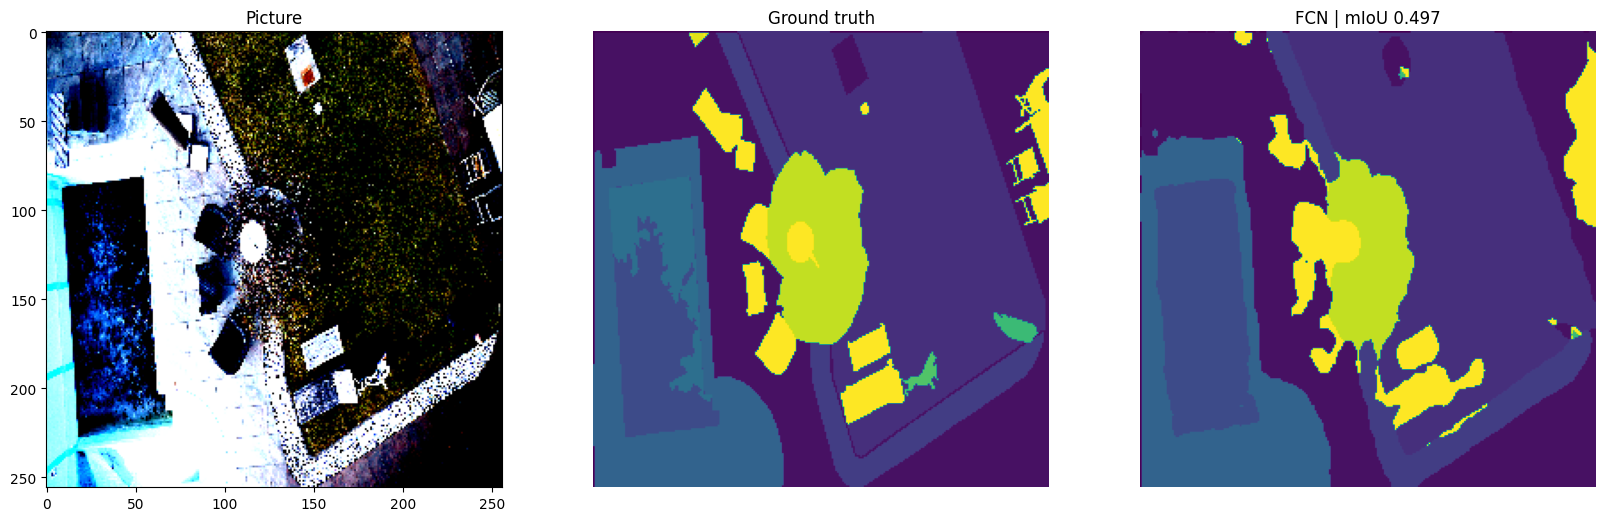

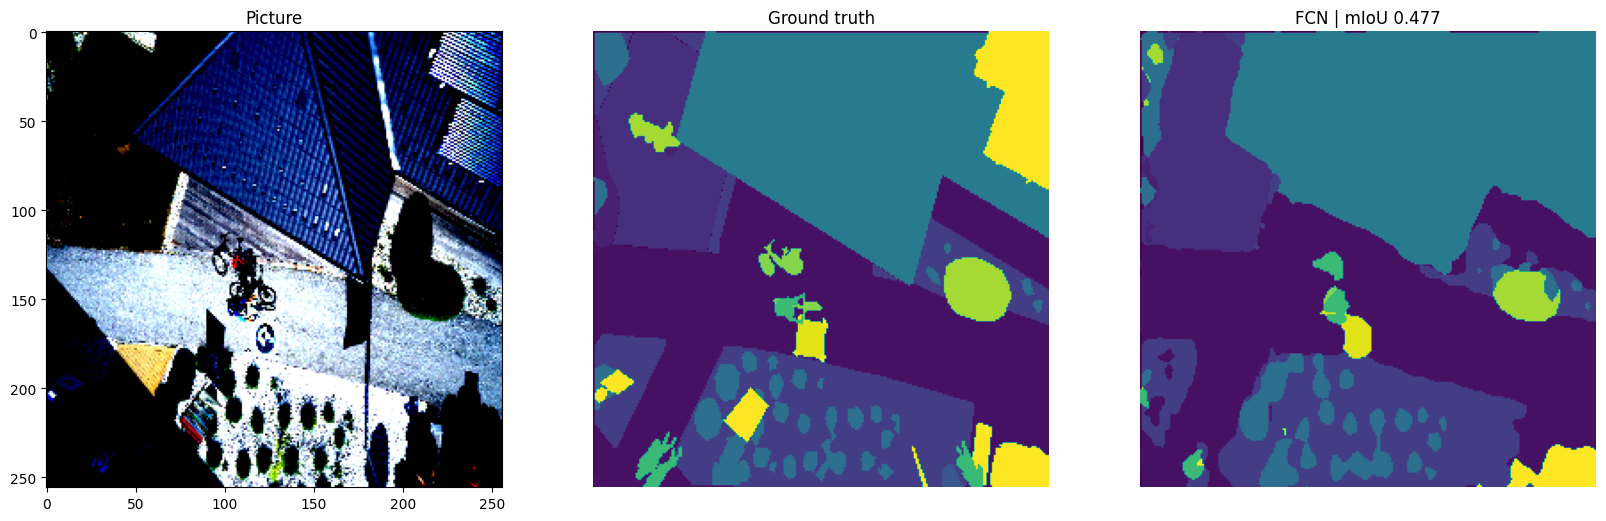

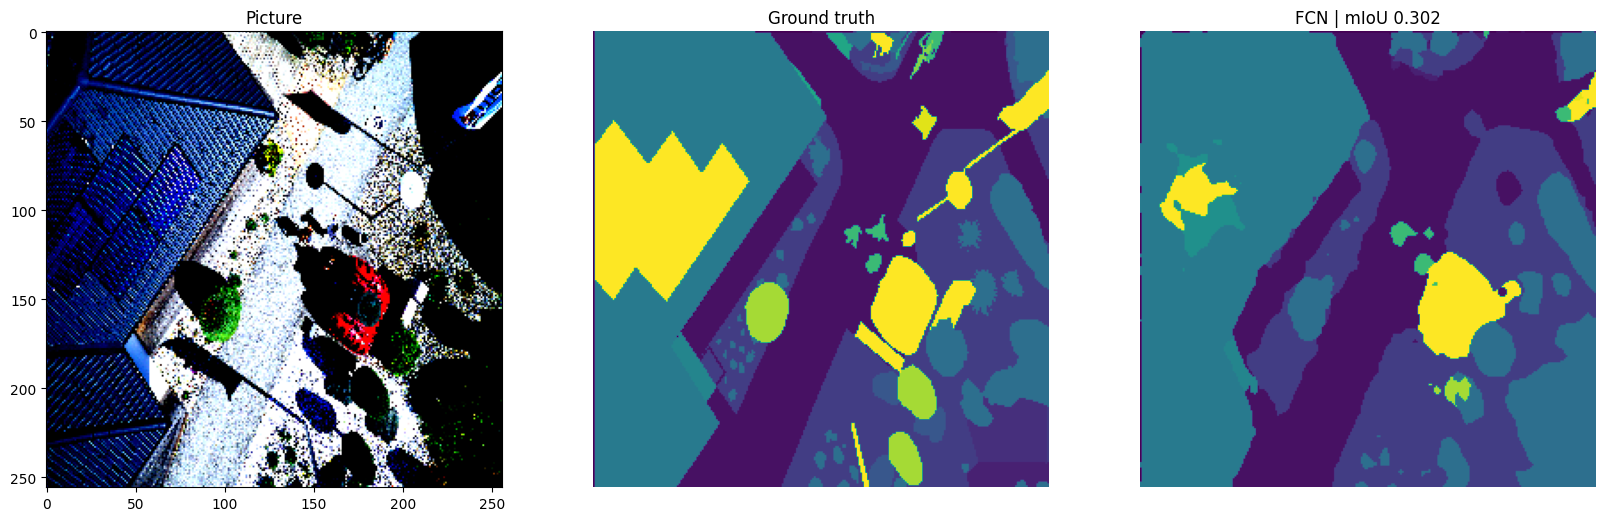

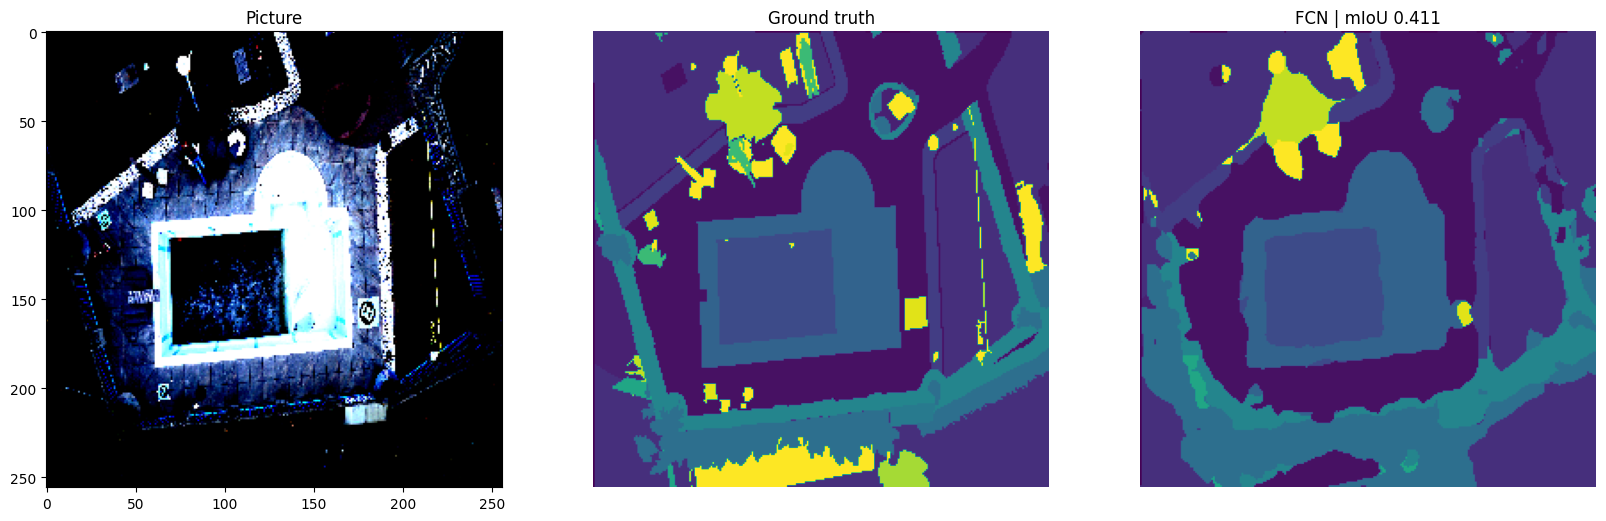

### Training&Validation&Testing help functions

In [10]:
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=24):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes):
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0:
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

In [11]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

In [50]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler=None, patch=False):
    torch.cuda.empty_cache()
    train_losses = []
    val_iou = []; val_acc = []
    train_iou = []; train_acc = []
    lrs = []
    min_loss = np.inf
    decrease = 1 ; not_improve=0

    model.to(DEVICE)
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0

        #training loop
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            #training phase
            image_tiles, mask_tiles = data
            if patch:
                bs, n_tiles, c, h, w = image_tiles.size()

                image_tiles = image_tiles.view(-1, c, h, w)
                mask_tiles = mask_tiles.view(-1, h, w)

            image = image_tiles.to(DEVICE)
            mask = mask_tiles.to(DEVICE)

            #forward
            output = model(image)
            loss = criterion(output, mask)

            #evaluation metrics
            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)

            #backward
            loss.backward()
            optimizer.step() #update weight
            optimizer.zero_grad() #reset gradient

            if scheduler is not None:
                lrs.append(get_lr(optimizer))
                scheduler.step()

            running_loss += loss.item()

        train_losses.append(running_loss/len(train_loader))
        train_iou.append(iou_score/len(train_loader))
        train_acc.append(accuracy/len(train_loader))

        torch.save(model, './models/model_last_epoch.pth')
        
        print("Epoch:{}/{}..".format(e+1, epochs),
                      "Loss: {:.3f}..".format(running_loss/len(train_loader)),
                      # "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),
                      "mIoU:{:.3f}..".format(iou_score/len(train_loader)),
                      # "Val mIoU: {:.3f}..".format(val_iou_score/len(val_loader)),
                      "Pixel Accuracy:{:.3f}..".format(accuracy/len(train_loader)),
                      # "Val Acc:{:.3f}..".format(test_accuracy/len(val_loader)),
                      "Time: {:.2f}m".format((time.time()-since)/60))

    history = {'train_loss' : train_losses,
               'train_miou' :train_iou,
               'train_acc' :train_acc}
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history



### Тренування

In [ ]:
torch.save(model, './models/model.pt')
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    'history': history,
}, './models/checkpoint.pth')

In [ ]:
# checkpoint = torch.load('./models/checkpoint.pth')
# model.load_state_dict(checkpoint['model_state_dict'], strict=False)
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'], strict=False)
# scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

# for param_group in optimizer.param_groups:
#     param_group['lr'] = new_learning_rate

# model = torch.load('./models/FCN8_VGG16_ImageNet.pt')

C:\Users\Anna\AppData\Local\Temp\ipykernel_34660\2398378555.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('./models/FCN8_VGG16_ImageNet.pt')


In [53]:
max_lr = 0.0001
epoch = 2
weight_decay = 1e-4

# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.AdamW(model.parameters(), weight_decay=weight_decay, lr=max_lr)

# optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))


# optimizer = torch.optim.AdamW(model.parameters(), weight_decay=weight_decay)
history = fit(epoch, model, train_loader, val_loader, criterion, optimizer, scheduler=sched)

100%|██████████| 43/43 [07:03<00:00,  9.84s/it]


Epoch:1/2.. Loss: 0.531.. mIoU:0.411.. Pixel Accuracy:0.831.. Time: 7.06m


100%|██████████| 43/43 [07:55<00:00, 11.07s/it]


Epoch:2/2.. Loss: 0.512.. mIoU:0.421.. Pixel Accuracy:0.838.. Time: 7.94m
Total time: 14.99 m


In [ ]:
plot_loss(history)
plot_score(history)
plot_acc(history)

### Тестування

In [73]:
image, mask = val_set[35]
pred_mask, score = predict_image_mask_miou(model, image, mask)

Output shape: torch.Size([1, 24, 256, 256])
Mask shape: torch.Size([1, 256, 256])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


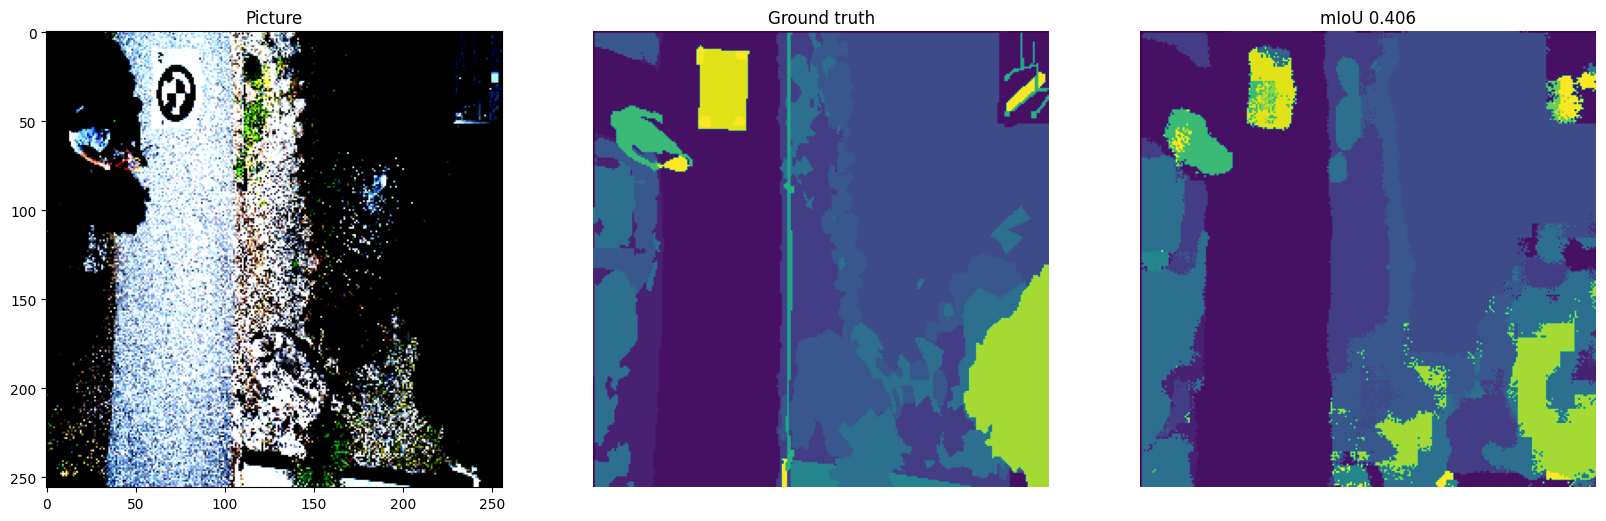

In [74]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image.permute(1, 2, 0).numpy())
ax1.set_title('Picture')

ax2.imshow(mask)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask)
ax3.set_title('mIoU {:.3f}'.format(score))
ax3.set_axis_off()